In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from com.nait.lib.recom.Recommend import RecommendArticles

In [3]:
v_conn = sqlite3.connect('studiesInput/NLPDocuments.db')

v_articles  = pd.read_sql_query("select * from Articles", v_conn)
v_articles  = v_articles.rename(columns = {'tabPK': 'article_id'})

for _ in range(2):
    try:
        v_userArticles = pd.read_sql_query("select * from userArticles", v_conn)
        v_userArticles.drop(['index'], axis = 1, inplace = True)
        break
    except:
        def emailMapper(p_data):
            v_coded_dict = dict()
            v_cter = 1
            v_email_encoded = []    
            for val in p_data['email']:
                if val not in v_coded_dict:
                    v_coded_dict[val] = v_cter
                    v_cter += 1

                v_email_encoded.append(v_coded_dict[val])
            return v_email_encoded

        v_userArticles = pd.read_csv('__inRecommendation/user-item-interactions.csv').drop('Unnamed: 0', axis = 1)
        v_userArticles['article_id'] = v_userArticles['article_id'].astype(int)
        v_userArticles['user_id']    = emailMapper(v_userArticles)
        v_userArticles.drop(['email', 'title'], axis = 1, inplace = True)
        v_userArticles = v_userArticles.append(pd.DataFrame({'user_id': -999, 'article_id': -999}, index = [-1]), ignore_index = True)
        v_userArticles.to_sql('userArticles', con = v_conn, index = False)

for _ in range(2):
    try:
        v_users = pd.read_sql_query("select * from Users", v_conn)
        break
    except:
        v_users = pd.DataFrame({'user_id': 1, 'username': 'test', 'password': 'test'}, index = [0])
        v_users.to_sql('Users', con = v_conn, index = False)

v_userArticlesMatrix = ( v_userArticles.groupby(['user_id', 'article_id'])
                                       .agg({'article_id': ['count']})
                                       .apply(lambda x: 1, axis = 1)
                                       .unstack() )
        
display(v_articles.head(3))
display(v_userArticles.head(3))
display(v_users.head(3))

,article_id,lang,title,topic_keywords,authors,authorsDet,article_date,content,tokens
0,0,eng,Identifying gaps in HIV policy and practice al...,"health, research, intervention, program, suppo...",Cawley C | McRobie E | Oti S | Njamwea B | Nya...,Author information: | Department of Population...,2017 Nov 1,last decade see rapid evolution guidance conce...,last | decade | see | rapid | evolution | guid...
1,1,eng,Feasibility and acceptability of HIV self-test...,"hiv, test, care, service, health, facility, cl...",Ngure K | Heffron R | Mugo N | Thomson KA | Ir...,Author information: | Department of Public Hea...,2017 Feb 10,hiv test key delivery pre-exposure prophylaxis...,hiv | test | key | delivery | pre-exposure | p...
2,2,eng,Integrated Delivery of Antiretroviral Treatmen...,"study, group, participant, trial, adherence, i...",Baeten JM | Heffron R | Kidoguchi L | Mugo NR ...,Author information: | Department of Global Hea...,2016 Aug 23,antiretroviral-based intervention hiv-1 preven...,antiretroviral-based | intervention | hiv-1 | ...


,article_id,user_id
0,1430,1
1,1314,2
2,1429,3


,password,user_id,username
0,test,1,test


In [4]:
v_data = v_userArticles.merge(v_articles, how = 'left', on = 'article_id')
display(v_data[v_data['title'].isnull()])

,article_id,user_id,lang,title,topic_keywords,authors,authorsDet,article_date,content,tokens
45993,-999,-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Explore the distribution of number of articles read by one user

Minimum number of articles read by top users: 48 (top 3%)


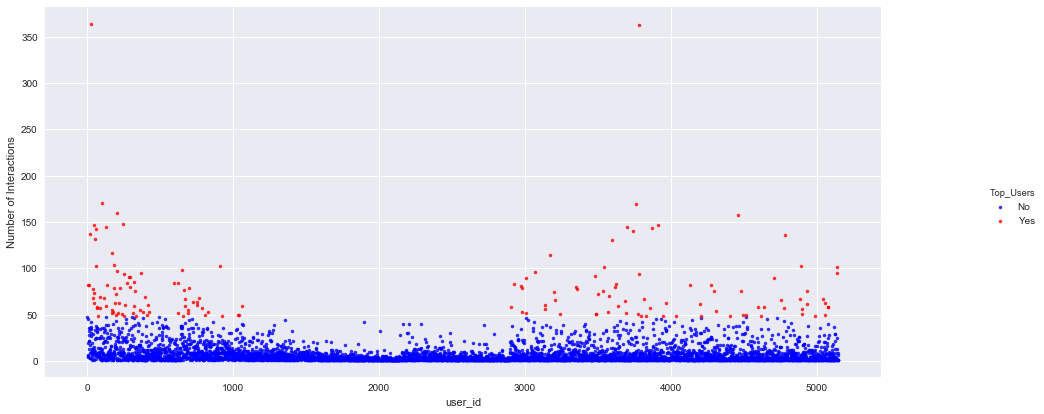

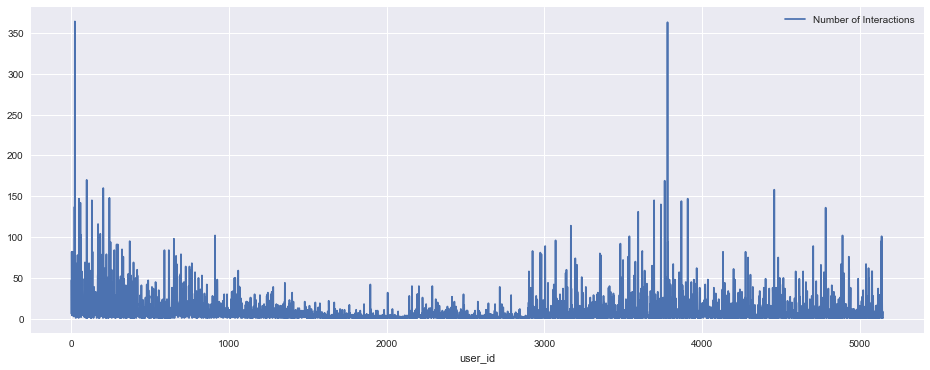

In [5]:
v_userArticleGroup = v_userArticles.groupby(['user_id']).agg({'user_id': ['count']})
v_userArticleGroup.columns = ['Number of Interactions']

v_topUsers = v_userArticleGroup['Number of Interactions'].quantile(0.97)
print(f'Minimum number of articles read by top users: {round(v_topUsers)} (top 3%)')

v_userArticleGroup['Top_Users'] = v_userArticleGroup['Number of Interactions'].apply(lambda x: 'Yes' if x >= v_topUsers else 'No' )

grid = sns.lmplot( data = v_userArticleGroup.drop(-999).reset_index(), 
                   x = 'user_id', y = 'Number of Interactions', hue = "Top_Users", 
                   markers = ".", fit_reg = False, palette= dict(Yes = "r", No = "b") )
grid.fig.set_figwidth(16)
grid.fig.set_figheight(6)
plt.show()

v_userArticleGroup.drop(-999).plot(figsize = (16, 6))
plt.show()

-------
### Explore the distribution of articles being read

Minimum number of times an articles has been read: 381 (top 3%)


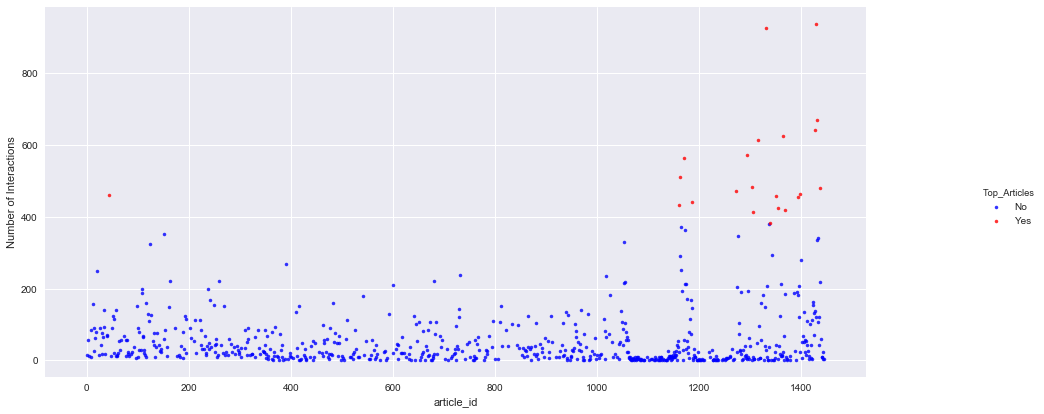

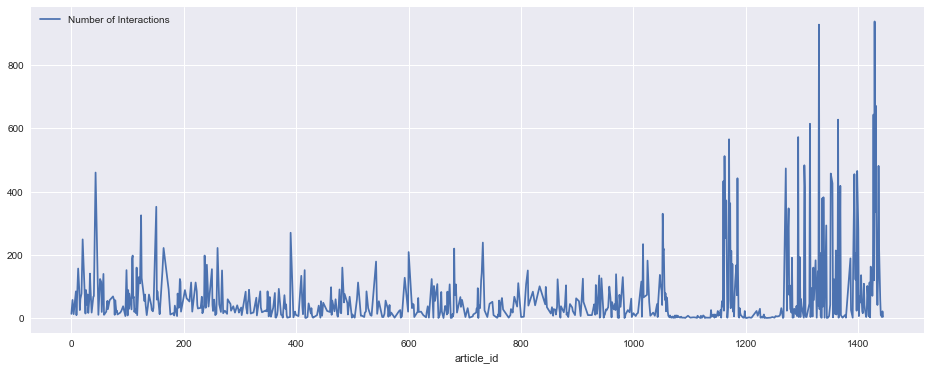

In [6]:
v_userArticleGroup = v_userArticles.groupby(['article_id']).agg({'article_id': ['count']})
v_userArticleGroup.columns = ['Number of Interactions']

v_topArticles = v_userArticleGroup['Number of Interactions'].quantile(0.97)
print(f'Minimum number of times an articles has been read: {round(v_topArticles)} (top 3%)')

v_userArticleGroup['Top_Articles'] = v_userArticleGroup['Number of Interactions'].apply(lambda x: 'Yes' if x >= v_topArticles else 'No' )

grid = sns.lmplot( data = v_userArticleGroup.drop(-999).reset_index(), 
                   x = 'article_id', y = 'Number of Interactions', hue = "Top_Articles", 
                   markers = ".", fit_reg = False, palette= dict(Yes = "r", No = "b") )
grid.fig.set_figwidth(16)
grid.fig.set_figheight(6)
plt.show()

v_userArticleGroup.drop(-999).plot(figsize = (16, 6))
plt.show()

----------
### User Recommendations

In [7]:
display( RecommendArticles( p_user_id              = 1, 
                            p_articles             = v_articles, 
                            p_userArticles         = v_userArticles,
                            p_userArticlesMatrix   = v_userArticlesMatrix ).getRecommendationsDetails() )

,article_id,title,topic_keywords,Article Read No,User ID,Keywords Similarity,User Articles Similarity,User Articles Read,User Articles Interactions
0,1330,Association between CD4+ T-lymphocyte counts a...,"art, patient, treatment, year, initiation, ant...",927,23,0,17.0,135,364
1,1364,Contraceptive method and pregnancy incidence a...,"woman, infant, increase, associate, month, com...",627,23,0,17.0,135,364
2,1314,Disease progression by infecting HIV-1 subtype...,"hiv-1, infection, response, cell, infect, plas...",614,23,0,17.0,135,364
3,1162,Concomitant contraceptive implant and efaviren...,"study, group, participant, trial, adherence, i...",512,23,0,17.0,135,364
4,1304,Morbidity among HIV-1-infected mothers in Keny...,"woman, infant, increase, associate, month, com...",483,23,0,17.0,135,364
5,1351,Preexposure prophylaxis for HIV infection amon...,"study, group, participant, trial, adherence, i...",457,23,0,17.0,135,364
6,1393,HIV status and treatment influence on fertilit...,"health, research, intervention, program, suppo...",455,23,0,17.0,135,364
7,1160,Knowledge about cervical cancer screening and ...,"hiv, test, care, service, health, facility, cl...",433,23,0,17.0,135,364
8,1354,Changes in glomerular kidney function among HI...,"study, group, participant, trial, adherence, i...",426,23,0,17.0,135,364
9,1338,Attitudes and acceptance of oral and parentera...,"study, group, participant, trial, adherence, i...",382,23,0,17.0,135,364


In [8]:
v_rec = RecommendArticles( p_user_id              = -999, 
                           p_articles             = v_articles, 
                           p_userArticles         = v_userArticles,
                           p_userArticlesMatrix   = v_userArticlesMatrix,
                           p_keywords             = ['child', 'woman', 'infant'] )
display(v_rec.getRecommendationsDetails())

,article_id,title,topic_keywords,Article Read No,Keywords Similarity,User ID,User Articles Similarity,User Articles Read,User Articles Interactions
0,1364,Contraceptive method and pregnancy incidence a...,"woman, infant, increase, associate, month, com...",627,3,NaN,NaN,NaN,NaN
1,1293,Highly active antiretroviral therapy versus zi...,"woman, infant, increase, associate, month, com...",572,3,NaN,NaN,NaN,NaN
2,1304,Morbidity among HIV-1-infected mothers in Keny...,"woman, infant, increase, associate, month, com...",483,3,NaN,NaN,NaN,NaN
3,1165,Cytomegalovirus viraemia is associated with po...,"woman, infant, increase, associate, month, com...",372,3,NaN,NaN,NaN,NaN
4,1398,Gaps in Adolescent Engagement in Antenatal Car...,"hiv, risk, men, partner, sexual, report, sex, ...",465,1,NaN,NaN,NaN,NaN
5,1276,Prevalence and factors associated with convuls...,"child, age, mortality, year, death, adult, rat...",347,1,NaN,NaN,NaN,NaN
6,1429,A Risk Assessment Tool for Identifying Pregnan...,"study, group, participant, trial, adherence, i...",937,0,NaN,NaN,NaN,NaN
7,1330,Association between CD4+ T-lymphocyte counts a...,"art, patient, treatment, year, initiation, ant...",927,0,NaN,NaN,NaN,NaN
8,1431,Frontloading HIV financing maximizes the achie...,"hiv, data, country, kenya, model, estimate, po...",671,0,NaN,NaN,NaN,NaN
9,1427,Uptake and correlates of contraception among p...,"hiv, test, care, service, health, facility, cl...",643,0,NaN,NaN,NaN,NaN


In [9]:
display( RecommendArticles( p_user_id              = 1, 
                            p_articles             = v_articles, 
                            p_userArticles         = v_userArticles,
                            p_userArticlesMatrix   = v_userArticlesMatrix ).getRecommendationsDetails() )

display( RecommendArticles( p_user_id              = 3933, 
                            p_articles             = v_articles, 
                            p_userArticles         = v_userArticles,
                            p_userArticlesMatrix   = v_userArticlesMatrix ).getRecommendationsDetails() )

display( RecommendArticles( p_user_id              = 23, 
                            p_articles             = v_articles, 
                            p_userArticles         = v_userArticles,
                            p_userArticlesMatrix   = v_userArticlesMatrix ).getRecommendationsDetails() )

display( RecommendArticles( p_user_id              = 3782, 
                            p_articles             = v_articles, 
                            p_userArticles         = v_userArticles,
                            p_userArticlesMatrix   = v_userArticlesMatrix ).getRecommendationsDetails() )

display( RecommendArticles( p_user_id              = -999, 
                            p_articles             = v_articles, 
                            p_userArticles         = v_userArticles,
                            p_userArticlesMatrix   = v_userArticlesMatrix ).getRecommendationsDetails() )

,article_id,title,topic_keywords,Article Read No,User ID,Keywords Similarity,User Articles Similarity,User Articles Read,User Articles Interactions
0,1330,Association between CD4+ T-lymphocyte counts a...,"art, patient, treatment, year, initiation, ant...",927,23,0,17.0,135,364
1,1364,Contraceptive method and pregnancy incidence a...,"woman, infant, increase, associate, month, com...",627,23,0,17.0,135,364
2,1314,Disease progression by infecting HIV-1 subtype...,"hiv-1, infection, response, cell, infect, plas...",614,23,0,17.0,135,364
3,1162,Concomitant contraceptive implant and efaviren...,"study, group, participant, trial, adherence, i...",512,23,0,17.0,135,364
4,1304,Morbidity among HIV-1-infected mothers in Keny...,"woman, infant, increase, associate, month, com...",483,23,0,17.0,135,364
5,1351,Preexposure prophylaxis for HIV infection amon...,"study, group, participant, trial, adherence, i...",457,23,0,17.0,135,364
6,1393,HIV status and treatment influence on fertilit...,"health, research, intervention, program, suppo...",455,23,0,17.0,135,364
7,1160,Knowledge about cervical cancer screening and ...,"hiv, test, care, service, health, facility, cl...",433,23,0,17.0,135,364
8,1354,Changes in glomerular kidney function among HI...,"study, group, participant, trial, adherence, i...",426,23,0,17.0,135,364
9,1338,Attitudes and acceptance of oral and parentera...,"study, group, participant, trial, adherence, i...",382,23,0,17.0,135,364


,article_id,title,topic_keywords,Article Read No,User ID,Keywords Similarity,User Articles Similarity,User Articles Read,User Articles Interactions
0,151,Optimising the cost and delivery of HIV counse...,"hiv, test, care, service, health, facility, cl...",352,1,0,35.0,36,47
1,1330,Association between CD4+ T-lymphocyte counts a...,"art, patient, treatment, year, initiation, ant...",927,23,0,17.0,135,364
2,1364,Contraceptive method and pregnancy incidence a...,"woman, infant, increase, associate, month, com...",627,23,0,17.0,135,364
3,1314,Disease progression by infecting HIV-1 subtype...,"hiv-1, infection, response, cell, infect, plas...",614,23,0,17.0,135,364
4,1162,Concomitant contraceptive implant and efaviren...,"study, group, participant, trial, adherence, i...",512,23,0,17.0,135,364
5,1304,Morbidity among HIV-1-infected mothers in Keny...,"woman, infant, increase, associate, month, com...",483,23,0,17.0,135,364
6,1351,Preexposure prophylaxis for HIV infection amon...,"study, group, participant, trial, adherence, i...",457,23,0,17.0,135,364
7,1393,HIV status and treatment influence on fertilit...,"health, research, intervention, program, suppo...",455,23,0,17.0,135,364
8,1160,Knowledge about cervical cancer screening and ...,"hiv, test, care, service, health, facility, cl...",433,23,0,17.0,135,364
9,1354,Changes in glomerular kidney function among HI...,"study, group, participant, trial, adherence, i...",426,23,0,17.0,135,364


,article_id,title,topic_keywords,Article Read No,User ID,Keywords Similarity,User Articles Similarity,User Articles Read,User Articles Interactions
0,225,Use of principal components analysis and prote...,"hiv-1, infection, response, cell, infect, plas...",31,3782,0,134.0,135,363
1,20,Modeling the Cost-Effectiveness of Home-Based ...,"hiv, data, country, kenya, model, estimate, po...",249,98,0,50.0,97,170
2,681,Infectious diarrhoea in antiretroviral therapy...,"child, age, mortality, year, death, adult, rat...",220,98,0,50.0,97,170
3,1054,Causes of death among persons of all ages with...,"child, age, mortality, year, death, adult, rat...",219,98,0,50.0,97,170
4,1274,Identification of Acute HIV-1 Infection by Hol...,"test, sample, result, screen, positive, case, ...",204,98,0,50.0,97,170
5,1324,Targeted deep sequencing of HIV-1 using the Io...,"hiv-1, infection, response, cell, infect, plas...",183,98,0,50.0,97,170
6,1422,HIV testing experiences and their implications...,"hiv, test, care, service, health, facility, cl...",163,98,0,50.0,97,170
7,116,Mucosal Blood Group Antigen Expression Profile...,"hiv-1, infection, response, cell, infect, plas...",160,98,0,50.0,97,170
8,1186,A Multi-Country Cross-Sectional Study of Vagin...,"child, age, mortality, year, death, adult, rat...",145,98,0,50.0,97,170
9,730,Prevalence of human papillomavirus in women wi...,"test, sample, result, screen, positive, case, ...",143,98,0,50.0,97,170


,article_id,title,topic_keywords,Article Read No,User ID,Keywords Similarity,User Articles Similarity,User Articles Read,User Articles Interactions
0,887,Multiple transitions and HIV risk among orphan...,"hiv, risk, men, partner, sexual, report, sex, ...",45,23,0,134.0,135,364
1,20,Modeling the Cost-Effectiveness of Home-Based ...,"hiv, data, country, kenya, model, estimate, po...",249,98,0,50.0,97,170
2,681,Infectious diarrhoea in antiretroviral therapy...,"child, age, mortality, year, death, adult, rat...",220,98,0,50.0,97,170
3,1054,Causes of death among persons of all ages with...,"child, age, mortality, year, death, adult, rat...",219,98,0,50.0,97,170
4,1274,Identification of Acute HIV-1 Infection by Hol...,"test, sample, result, screen, positive, case, ...",204,98,0,50.0,97,170
5,1324,Targeted deep sequencing of HIV-1 using the Io...,"hiv-1, infection, response, cell, infect, plas...",183,98,0,50.0,97,170
6,1422,HIV testing experiences and their implications...,"hiv, test, care, service, health, facility, cl...",163,98,0,50.0,97,170
7,116,Mucosal Blood Group Antigen Expression Profile...,"hiv-1, infection, response, cell, infect, plas...",160,98,0,50.0,97,170
8,1186,A Multi-Country Cross-Sectional Study of Vagin...,"child, age, mortality, year, death, adult, rat...",145,98,0,50.0,97,170
9,730,Prevalence of human papillomavirus in women wi...,"test, sample, result, screen, positive, case, ...",143,98,0,50.0,97,170


,article_id,title,topic_keywords,Article Read No,Keywords Similarity,User ID,User Articles Similarity,User Articles Read,User Articles Interactions
0,1429,A Risk Assessment Tool for Identifying Pregnan...,"study, group, participant, trial, adherence, i...",937,0,NaN,NaN,NaN,NaN
1,1330,Association between CD4+ T-lymphocyte counts a...,"art, patient, treatment, year, initiation, ant...",927,0,NaN,NaN,NaN,NaN
2,1431,Frontloading HIV financing maximizes the achie...,"hiv, data, country, kenya, model, estimate, po...",671,0,NaN,NaN,NaN,NaN
3,1427,Uptake and correlates of contraception among p...,"hiv, test, care, service, health, facility, cl...",643,0,NaN,NaN,NaN,NaN
4,1364,Contraceptive method and pregnancy incidence a...,"woman, infant, increase, associate, month, com...",627,0,NaN,NaN,NaN,NaN
5,1314,Disease progression by infecting HIV-1 subtype...,"hiv-1, infection, response, cell, infect, plas...",614,0,NaN,NaN,NaN,NaN
6,1293,Highly active antiretroviral therapy versus zi...,"woman, infant, increase, associate, month, com...",572,0,NaN,NaN,NaN,NaN
7,1170,Risk factors for treatment denial and loss to ...,"art, patient, treatment, year, initiation, ant...",565,0,NaN,NaN,NaN,NaN
8,1162,Concomitant contraceptive implant and efaviren...,"study, group, participant, trial, adherence, i...",512,0,NaN,NaN,NaN,NaN
9,1304,Morbidity among HIV-1-infected mothers in Keny...,"woman, infant, increase, associate, month, com...",483,0,NaN,NaN,NaN,NaN
